In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [118]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [119]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [120]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

In [121]:
print(len(X_train))

75000


In [122]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [123]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm

In [125]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [126]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [127]:
'''
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
     'gamma': [0.001, 0.01, 0.1, 1]
 }
'''
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# cv=3 [1,3,5,7,9,11], [25,39,99,149], [199, 249, 349, 449, 549, 649, 999] done
# cv= 5 [1,3,5,7,9,11], [11, 149, 649, 1299] , [1299, 1599, 1999, 2399] done
parameters = {
     'n_neighbors':[11, 149,1299, 2399]
 }

In [128]:
#gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='linear'), 
#                      parameters, cv=5, iid=True, n_jobs=-1, verbose=4)

knn = KNeighborsClassifier()

gs_clf = GridSearchCV(knn, parameters, cv = 5, n_jobs=-1, verbose=20)  # scoring = 'accuracy'

In [129]:
model = gs_clf.fit(X_train_f, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  3.3min remaining: 18.6min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  3.3min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  3.4min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  3.4min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  3.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:  3.6min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  3.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  3.7min remaining:   39.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.9min finished


In [130]:
print (model.cv_results_)

print (model.best_score_)
print (model.best_params_)
print (model.best_estimator_)

{'mean_fit_time': array([0.06505842, 0.0655117 , 0.0653275 , 0.08417382]), 'std_fit_time': array([0.00039418, 0.00080478, 0.00127651, 0.02924114]), 'mean_score_time': array([39.91837134, 40.29998322, 42.83437505, 45.88284354]), 'std_score_time': array([0.43640255, 0.47351292, 0.5087516 , 0.35165435]), 'param_n_neighbors': masked_array(data=[11, 149, 1299, 2399],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 11}, {'n_neighbors': 149}, {'n_neighbors': 1299}, {'n_neighbors': 2399}], 'split0_test_score': array([0.58126667, 0.59353333, 0.60093333, 0.5946    ]), 'split1_test_score': array([0.55853333, 0.57973333, 0.59213333, 0.59453333]), 'split2_test_score': array([0.56246667, 0.59486667, 0.60713333, 0.60413333]), 'split3_test_score': array([0.5562    , 0.5824    , 0.61293333, 0.6222    ]), 'split4_test_score': array([0.56466667, 0.57686667, 0.59946667, 0.59766667]), 'mean_test_score': array([0.56462667, 0.58548 

In [16]:
pickle.dump(model,open("knn_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [108]:
# plot k vs mean_test_score from  GridSearchCV
def GridSearchCV_result():
    k_vector= [1,3,5,7,9, 11, 25,39,99,149,649, 1299,1599, 1999, 2399];
    accuracy_vector= [  0.53366667, 0.55422667, 0.56184   , 0.56152   , 0.56281333,
       0.56462667, # 1,3,5,7,9,11
                       0.57049333, 0.57313333, 0.58334667, 0.58548, # 25,39,99, 149
                        0.59865333, 0.60252, 0.60024, # 649, 1299,1599
                        0.60077333, 0.60262667]; # 1999, 2399
        
        
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(k_vector,accuracy_vector,label='Accuracy vs k',marker='o')
    
    plt.title("Accuracy vs K")
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    fig.savefig("knn_k_vs_Acc_plot.png")
    print("Best accuracy= %.4f"%max(accuracy_vector))
    #print(accuracy_vector.index(max(accuracy_vector)))
    print("For k= %d"%k_vector[accuracy_vector.index(max(accuracy_vector))])



Best accuracy= 0.6026
For k= 2399


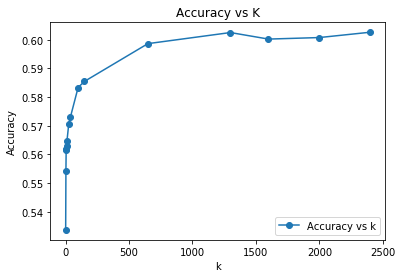

In [109]:
#GridSearchCV_result()


In [131]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [132]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [133]:
from sklearn.metrics import accuracy_score

In [135]:

n_trainSamples = [10000,20000,50000,75000] # edited to have size> 2399 (best k)

valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    '''
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        kernel='linear',
                        C=model.best_params_['C'])
    '''
    bestModel = KNeighborsClassifier(n_neighbors= model.best_params_['n_neighbors'],  algorithm='auto',n_jobs=-1)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    print("------------------------------------")
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    

SampleSize: 10000
Train Time:3.26 sec
Validation Accuracy: 54.85%
Validation Time:11.14 sec
Test Accuracy: 55.55%
Test Time:11.03 sec
(0.4918338143338158, 0.24466666666666667, 0.6406666666666667)
MRR: 0.4918338143338158
MRR Time:9.61 sec
------------------------------------
SampleSize: 20000
Train Time:5.83 sec
Validation Accuracy: 56.15%
Validation Time:16.10 sec
Test Accuracy: 56.11%
Test Time:16.14 sec
(0.4927012987013, 0.25, 0.6426666666666667)
MRR: 0.4927012987013
MRR Time:15.12 sec
------------------------------------
SampleSize: 50000
Train Time:14.72 sec
Validation Accuracy: 56.93%
Validation Time:27.34 sec
Test Accuracy: 56.93%
Test Time:30.46 sec
(0.5045356421356427, 0.264, 0.648)
MRR: 0.5045356421356427
MRR Time:28.34 sec
------------------------------------
SampleSize: 75000
Train Time:21.82 sec
Validation Accuracy: 57.31%
Validation Time:39.07 sec
Test Accuracy: 56.67%
Test Time:39.04 sec
(0.5033464165464173, 0.266, 0.6466666666666666)
MRR: 0.5033464165464173
MRR Time:42.4

In [143]:

print ("Val accuracy:")
print (valAccuracy)
print ("Test accuracy:")
print (testAccuracy)
print ("MRR score:")
print (mrrScore)
print ("precision At1:")
print (precisionAt1)
print ("precision At3:")
print (precisionAt3)

Val accuracy:
[0.5485, 0.5615, 0.5693, 0.5731]
Test accuracy:
[0.5555, 0.5611, 0.5693, 0.5667]
MRR score:
[0.4918338143338158, 0.4927012987013, 0.5045356421356427, 0.5033464165464173]
precision At1:
[0.24466666666666667, 0.25, 0.264, 0.266]
precision At3:
[0.6406666666666667, 0.6426666666666667, 0.648, 0.6466666666666666]


In [137]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Accuracy vs TrainData size")
    plt.legend()
    plt.xlabel("TrainData size")
    plt.ylabel("Accuracy")
    fig.savefig("knn2399_Tokens_Accuracy.png")
    #plt.show()

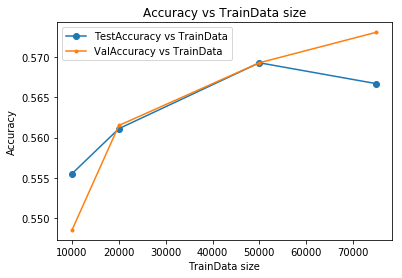

In [138]:
accuracyVisualization()

In [139]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("MRR vs TrainData size")
    plt.legend()
    plt.xlabel("TrainData size")
    plt.ylabel("MRR")
    fig.savefig("knn2399_Tokens_Mrr.png")
    plt.show()

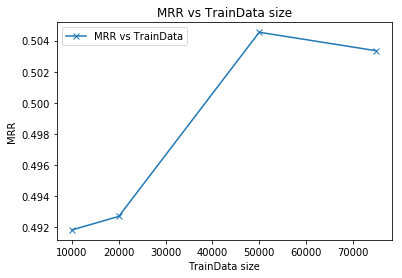

In [140]:
mrrVisualization()

In [141]:
def precisionVisualization():
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='o')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='x')
    plt.title("Precision vs TrainData size")
    plt.legend()
    plt.xlabel("TrainData size")
    plt.ylabel("Precision")
    fig.savefig("knn2399_Tokens_Precision.png")
    #plt.show()

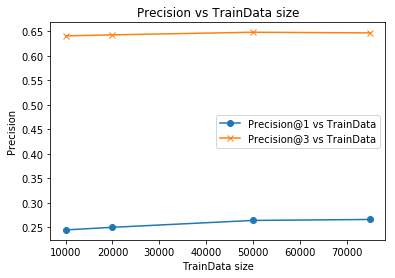

In [142]:
precisionVisualization()